#**Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

#**Explorasi Data Analysis**

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,Age,Income,Student,Credit_Rating,Buys_Computer
0,Tua,Tinggi,Ya,Buruk,0
1,Paruh Baya,Tinggi,Ya,Baik,1
2,Paruh Baya,Rendah,Tidak,Buruk,1
3,Tua,Rendah,Tidak,Baik,1
4,Tua,Rendah,Ya,Baik,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            1000 non-null   object
 1   Income         1000 non-null   object
 2   Student        1000 non-null   object
 3   Credit_Rating  1000 non-null   object
 4   Buys_Computer  1000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


In [4]:
df.describe()

,Buys_Computer
count,1000.000000
mean,0.669000
std,0.470809
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [5]:
df.describe(include='object')

,Age,Income,Student,Credit_Rating
count,1000,1000,1000,1000
unique,3,3,2,2
top,Paruh Baya,Tinggi,Ya,Buruk
freq,346,347,510,526


In [6]:
df.isnull().sum()

,0
Age,0
Income,0
Student,0
Credit_Rating,0
Buys_Computer,0


tidak ada missing value pada data

In [7]:
for col in df.columns:
    print(f"\nUnique values in {col}:")
    print(df[col].unique())


Unique values in Age:
['Tua' 'Paruh Baya' 'Muda']

Unique values in Income:
['Tinggi' 'Rendah' 'Sedang']

Unique values in Student:
['Ya' 'Tidak']

Unique values in Credit_Rating:
['Buruk' 'Baik']

Unique values in Buys_Computer:
[0 1]


Mengecek Distribusi Target

In [9]:
print(df['Buys_Computer'].value_counts())

Buys_Computer
1    669
0    331
Name: count, dtype: int64


dapat dilihat bahwa pada target itu mengalami imbalanced data. maka dari itu, kita bisa melakukan sampling terlebih dahulu.

#**Preprocessing**

Melakukan Encoding

In [8]:
df_encoded = df.copy()
label_encoder = LabelEncoder()

for col in ['Age', 'Income']:
    df_encoded[col + '_encoded'] = label_encoder.fit_transform(df[col])

df_encoded = pd.get_dummies(df_encoded, columns=['Student', 'Credit_Rating'], drop_first=False, dtype=int)
df_encoded.drop(['Age', 'Income'], axis=1, inplace=True)
buys_computer_col = df_encoded.pop('Buys_Computer')
df_encoded['Buys_Computer'] = buys_computer_col
df_encoded.head()

,Age_encoded,Income_encoded,Student_Tidak,Student_Ya,Credit_Rating_Baik,Credit_Rating_Buruk,Buys_Computer
0,2,2,0,1,0,1,0
1,1,2,0,1,1,0,1
2,1,0,1,0,0,1,1
3,2,0,1,0,1,0,1
4,2,0,0,1,1,0,1


Melakukan Data Spliting

In [10]:
X = df_encoded.iloc[:, :-1].values
y = df_encoded.iloc[:, -1].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Melakukan Oversampling menggunakan SMOTE

In [11]:
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

Menampilkan distribusi setelah SMOTE

In [12]:
print("\nSetelah SMOTE:")
print("X_train_oversampled shape:", X_train_oversampled.shape)
print("y_train_oversampled shape:", y_train_oversampled.shape)
print("Distribusi label setelah SMOTE:", dict(zip(*np.unique(y_train_oversampled, return_counts=True))))


Setelah SMOTE:
X_train_oversampled shape: (940, 6)
y_train_oversampled shape: (940,)
Distribusi label setelah SMOTE: {np.int64(0): np.int64(470), np.int64(1): np.int64(470)}


# **Pelatihan dan Evaluasi Model**

Menggunakan algoritma Naive Bayes

In [13]:
model = GaussianNB()
model.fit(X_train_oversampled, y_train_oversampled)

GaussianNB()

Melakukan Evaluasi

In [14]:
y_pred = model.predict(X_test)
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan klasifikasi:\n", classification_report(y_test, y_pred))

Akurasi: 0.7
Laporan klasifikasi:
               precision    recall  f1-score   support

           0       0.54      0.74      0.62       101
           1       0.84      0.68      0.75       199

    accuracy                           0.70       300
   macro avg       0.69      0.71      0.69       300
weighted avg       0.74      0.70      0.71       300



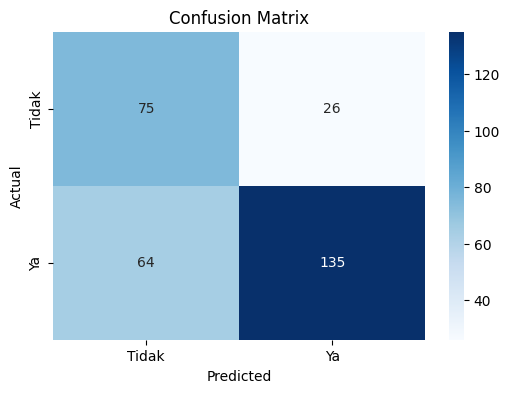

In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak', 'Ya'], yticklabels=['Tidak', 'Ya'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Model cukup baik dalam mengenali kelas mayoritas ("Ya"), terlihat dari nilai TP = 135. Namun masih terdapat kesalahan cukup tinggi pada prediksi negatif. FN = 64, artinya model cukup sering gagal mengenali data "Ya".